In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
import tensorflow as tf
import gym
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]
tf.keras.backend.set_floatx('float64')

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.debugging.set_log_device_placement(True)

In [6]:
env = gym.make('Pendulum-v0')

In [19]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)

class ReplayMemory:
    
    def __init__(self, max_size, state_dim, action_dim):
        self.max_size = max_size
        self.state_dim = state_dim
        
        self.states = np.random.random((max_size, state_dim), device='cuda')
        self.actions = np.random.random((max_size, action_dim), device='cuda')
        self.rewards = np.random.random((max_size, 1), device='cuda')
        self.next_states = np.random.random((max_size, state_dim), device='cuda')
        self.dones = np.full((max_size, 1), True)
        
        self.idx = 0
        self.size = 0
    
    def add(self, state, action, reward, next_state, done):
        
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done
        
        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample(self, batch_size):
        if self.size <= batch_size:
            sample_indices = np.random.choice(self.size, self.size, replace=False)
        else:
            sample_indices = np.random.choice(self.size, batch_size, replace=False)
        batch = Batch(
                        states = self.states[ sample_indices ,:],
                        actions = self.actions[ sample_indices ,:],
                        rewards = self.rewards[ sample_indices ,:],
                        next_states = self.next_states[ sample_indices ,:],
                        dones = self.dones[ sample_indices ,:]
                    )
        return batch

    def populate(self, env, num_steps):
        state = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            self.add(state, action, reward, next_state, done)
            if done:
                state = env.reset()
            state = next_state
        

In [20]:
class Network:
    def __init__(self, input_size, hidden_layers_count, output_size, nodes_count=512):
        self.model = Sequential()
        self.model.add(InputLayer(input_size))
        for _ in range(hidden_layers_count):
            self.model.add(Dense(nodes_count, activation='relu'))
        self.model.add(Dense(output_size, activation='tanh'))
        
    

In [21]:
def huber_loss(x, delta=1.):
    """
    Compute the huber loss.
    https://en.wikipedia.org/wiki/Huber_loss
    :param x (np.ndarray or tf.Tensor): Values to compute the huber loss.
    :param delta (float): Positive floating point value. Represents the
                          maximum possible gradient magnitude.
    :return (tf.Tensor): The huber loss.
    """
    delta = tf.ones_like(x) * delta
    less_than_max = 0.5 * tf.square(x)
    greater_than_max = delta * (tf.abs(x) - 0.5 * delta)
    return tf.where(
        tf.abs(x) <= delta,
        x=less_than_max,
        y=greater_than_max)

class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): 
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)



In [25]:
class DDPG:
    
    def __init__(self, state_size, action_size, actor_learning_rate=0.0001, critic_learning_rate=0.0001, gamma=0.99, tau=0.005):
        self.state_size = state_size
        self.action_size = action_size
        self.actor_lr = actor_learning_rate
        self.critic_lr = critic_learning_rate
        self.gamma = gamma
        self.tau = tau
        
        self.critic = Network(state_size + action_size, 3, action_size).model
        self.target_critic = Network(state_size + action_size, 3, action_size).model
        
        self.actor = Network(state_size, 3, action_size).model
        self.target_actor = Network(state_size, 3, action_size).model
        
        self.critic_optimizer = Adam(learning_rate=self.critic_lr)
        self.actor_optimizer = Adam(learning_rate=self.actor_lr)
        
        self.critic_loss_method = tf.keras.losses.MeanSquaredError()
        self.ou = None
        self.build()
    
    def update_weights(self, base_model, target_model, tau):
        for base_layer, target_layer in zip(base_model.weights, target_model.weights):
            target_layer.assign(tau * base_layer + (1 - tau) * target_layer)
            
    def build(self):
        self.update_weights(self.actor, self.target_actor, tau = 1)
        self.update_weights(self.critic, self.target_critic, tau = 1)
    
    def generate_noise(self, size):
        return tf.random.normal(shape=(size, self.action_size), mean=0, stddev=0.1, dtype=tf.float64)
    
    def actions(self, states):
        actions_ = self.actor(states)
        #print(actions_)
        noised_actions = ou.get_action(actions_)
        #print(noised_actions)
        return noised_actions
        #noise = self.generate_noise(states.shape[0])
        #return tf.clip_by_value(actions_ + noise, -1, 1)
        
    @tf.function
    def train(self, states, actions, rewards, next_states, dones):
        
        target_next_actions = self.target_actor(next_states)
        q_dash_next_state = self.target_critic(tf.concat([next_states, target_next_actions], axis=1))
        not_dones = tf.cast(tf.math.logical_not(dones), dtype=tf.float64)
        q_dash = self.gamma * q_dash_next_state * not_dones + rewards
        with tf.GradientTape() as critic_tape:
            tf.stop_gradient(q_dash)
            q_ = self.critic(tf.concat([states, actions], axis=1))
            critic_loss = self.critic_loss_method(q_dash, q_)
        critic_gradients = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients( zip(critic_gradients, self.critic.trainable_variables))    
        
        with tf.GradientTape() as actor_tape:
            predicted_actions = self.actor(states)
            actor_loss = -tf.reduce_mean(self.critic(tf.concat([states, predicted_actions], axis=1)))
            
        actor_gradients = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
        self.update_weights(self.actor, self.target_actor, self.tau)
        self.update_weights(self.critic, self.target_critic, self.tau)
        return critic_loss, actor_loss
        
    def assign_ou(self, ou):
        self.ou = ou
        

In [33]:
TIMESTEPS = 15_00_000
BATCH_SIZE = 4
state_dim = 3
action_dim = 1
memory_size = 50000
replay_memory = ReplayMemory(memory_size, state_dim, action_dim)
replay_memory.populate(env, 10000)
critic_losses = []
actor_losses = []

ou = OUNoise(env.action_space)
ddpg = DDPG(state_dim, action_dim)
ddpg.assign_ou(ou)
counter = 0
state = env.reset()
# state = np.concatenate((state["observation"], state["achieved_goal"], state["desired_goal"]), axis=0)
pbar = tqdm.tnrange(TIMESTEPS, ncols='100%')
for t_total in pbar:
    action = ddpg.actions(np.array([state]))
    next_state, reward, done, info = env.step(np.array(action)[0])
    #next_state = np.concatenate((next_state["observation"], next_state["achieved_goal"], next_state["desired_goal"]), axis=0)
    replay_memory.add(state, action, reward, next_state, done)
    if t_total != 0 and t_total % 4 == 0:
        experience_batch = replay_memory.sample(4)
        critic_loss, actor_loss = ddpg.train(experience_batch.states, experience_batch.actions, experience_batch.rewards, experience_batch.next_states, experience_batch.dones)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
    if t_total != 0 and t_total % 100000 == 0:
        ddpg.target_actor.save_weights("model" + str(counter))
        print("saved")
        counter += 1
    if done:
        state = env.reset()
        ou = OUNoise(env.action_space)
        ddpg.assign_ou(ou)
        # state = np.concatenate((state["observation"], state["achieved_goal"], state["desired_goal"]), axis=0)
    else:
        state = next_state  
            

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

In [30]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

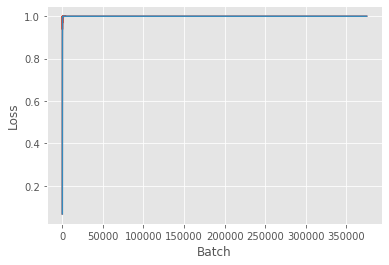

In [44]:
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(np.arange(1, len(actor_losses) + 1), actor_losses)
plt.plot(np.arange(1, len(actor_losses) + 1), rolling_average(actor_losses, window_size=150))

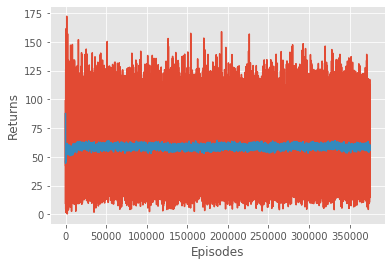

In [45]:
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.plot(np.arange(1, len(critic_losses) + 1), critic_losses)
plt.plot(np.arange(1, len(critic_losses) + 1), rolling_average(critic_losses, window_size=150))

In [46]:
state = env.reset()
for _ in range(1000):
    env.render()
    # state = np.concatenate((state["observation"], state["achieved_goal"], state["desired_goal"]), axis=0)
    action = ddpg.target_actor(np.array([state]))
    t = env.step(np.array(action)[0])
    if t[-2]:
        print(t)
        break
env.close()

(array([ 0.21631512,  0.9763236 , -0.87966651]), -2.2080566651733475, True, {'TimeLimit.truncated': True})


Batch(states=array([[ 1.34092599e+00,  7.47469543e-01,  5.33159306e-01,
         0.00000000e+00,  0.00000000e+00, -3.28467402e-04,
        -5.86900893e-04, -5.86487850e-04,  8.05025307e-06,
         1.62700503e-05,  1.34092599e+00,  7.47469543e-01,
         5.33159306e-01,  1.47894227e+00,  6.12456150e-01,
         5.93911463e-01],
       [ 1.34139961e+00,  7.48319439e-01,  5.33977366e-01,
         0.00000000e+00,  0.00000000e+00, -3.72670471e-04,
        -6.61853537e-04, -6.49905804e-04,  1.91377654e-05,
        -1.74648028e-05,  1.34139961e+00,  7.48319439e-01,
         5.33977366e-01,  1.47894227e+00,  6.12456150e-01,
         5.93911463e-01]]), actions=array([[-0.01493023, -0.02549686, -0.02170072, -0.03868279],
       [-0.01493575, -0.02547976, -0.02171363, -0.03870109]]), rewards=array([[-1.],
       [-1.]]), next_states=array([[ 1.34045787e+00,  7.46626901e-01,  5.32348305e-01,
         0.00000000e+00,  0.00000000e+00, -3.33067086e-04,
        -5.95844457e-04, -5.92400449e-04,  

{'observation': array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06]),
 'achieved_goal': array([1.34183265, 0.74910039, 0.53472272]),
 'desired_goal': array([1.31576882, 0.60519969, 0.39127637])}

In [248]:
cc = replay_memory.dones
cc

array([[False],
       [False],
       [False],
       [False],
       [False]])

In [144]:
intd_dones = tf.cast(1 - cc, dtype=tf.float64)

In [46]:
tf.constant(1 - cc, dtype=tf.float64)

<tf.Tensor: id=25154443, shape=(5, 1), dtype=float64, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])>

In [5]:
import numpy as np
np.linspace(0, 10_00_00, 10 , endpoint=False)

array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
       80000., 90000.])